*   This is to support part V.B.ii in our paper
*   We factor sentiment element into Tweets and then visualize the relationship between Apple stock price and Tweets

In [ ]:
%matplotlib inline 

import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Use dataframe that we exported from coding file "V_A_Tweet_Sentiment_Analysis" and stock price data from Kaggle
Apple = pd.read_csv('Apple.csv')
company_value = pd.read_csv('CompanyValues.csv')
company_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [ ]:
#Add column of daily returns into the stock price table
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Apple_value = company_value[company_value['ticker_symbol']=='AAPL'].sort_values('day_date')
Apple_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
2516,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943,NaN
2515,AAPL,2010-06-02,37.7071,171594061,37.7914,37.8286,37.1907,0.011961
2514,AAPL,2010-06-03,37.5886,162341809,37.8828,37.9357,37.2014,-0.003143
2513,AAPL,2010-06-04,36.5664,189045767,36.8871,37.4143,36.3757,-0.027194
2512,AAPL,2010-06-07,35.8486,221253336,36.8986,37.0214,35.7928,-0.019630


In [ ]:
#Merge Tweets content and stock price dataframe
Apple_tweet_vs_value =  pd.merge(Apple, Apple_value, left_on=['post_date'], right_on = ['day_date'], how= "inner")
Apple_tweet_vs_value['post_date'] = Apple_tweet_vs_value['post_date'].apply(lambda date: pd.to_datetime(date))
Apple_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,sentiment_scores,score,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns
0,0,0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0
1,1,2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0
2,2,5,550803225113157632,AAPL,MacHashNews,2015-01-01,Rumor Roundup: What to expect when you're expe...,0,0,0,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0
3,3,6,550802957370159104,AAPL,WaltLightShed,2015-01-01,"An $AAPL store line in Sapporo Japan for the ""...",2,4,4,...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",Positive,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0
4,4,7,550802855129382912,AAPL,2waystrading,2015-01-01,$AAPL - Will $AAPL Give Second entry opportuni...,0,0,0,...,"{'neg': 0.0, 'neu': 0.763, 'pos': 0.237, 'comp...",Positive,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0


In [ ]:
#Allocate the numeric score into n_score attribute for each sentiment status: Positive = 1; Neutral = 0.5; Negative = -1
n_score = []
for i in range(len(Apple_tweet_vs_value['score'])):
    if Apple_tweet_vs_value['score'][i] == 'Positive':
        n_score.append(1)
    elif Apple_tweet_vs_value['score'][i] == 'Neutral':
        n_score.append(0.5)
    elif Apple_tweet_vs_value['score'][i] == 'Negative':
        n_score.append(-1)
Apple_tweet_vs_value['n_score'] = n_score
Apple_tweet_vs_value.head(100)

#Calculate the total score of each Tweet
total_score = []
for i in range(len(Apple_tweet_vs_value['total_engangement'])):
    total_score.append(Apple_tweet_vs_value['total_engangement'][i]*Apple_tweet_vs_value['n_score'][i])

Apple_tweet_vs_value['total_score'] = total_score
Apple_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns,n_score,total_score
0,0,0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,...,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0,0.5,0.5
1,1,2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,...,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0,0.5,0.5
2,2,5,550803225113157632,AAPL,MacHashNews,2015-01-01,Rumor Roundup: What to expect when you're expe...,0,0,0,...,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0,0.5,0.0
3,3,6,550802957370159104,AAPL,WaltLightShed,2015-01-01,"An $AAPL store line in Sapporo Japan for the ""...",2,4,4,...,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0,1.0,10.0
4,4,7,550802855129382912,AAPL,2waystrading,2015-01-01,$AAPL - Will $AAPL Give Second entry opportuni...,0,0,0,...,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.21,0.0,1.0,0.0


In [ ]:
#Extract data that we want to visualize
Apple_visual = Apple_tweet_vs_value[['post_date','score','total_score','returns', 'close_value']]
Apple_visual.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Neutral,0.5,0.0,110.38
1,2015-01-01,Neutral,0.5,0.0,110.38
2,2015-01-01,Neutral,0.0,0.0,110.38
3,2015-01-01,Positive,10.0,0.0,110.38
4,2015-01-01,Positive,0.0,0.0,110.38


In [ ]:
#Group the data by post_date
Apple_visual_group = Apple_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()
Apple_visual_group

<ipython-input-8-7ca67b38a09c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Apple_visual_group = Apple_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()


,close_value,returns,total_score
post_date,,,
2015-01-01,110.38,0.000000,4.749164
2015-01-02,109.33,-0.009513,1.584775
2015-01-03,109.33,0.000000,0.536127
2015-01-04,109.33,0.000000,1.434729
2015-01-05,106.25,-0.028172,0.438971
...,...,...,...
2019-12-27,289.80,-0.000379,0.969816
2019-12-28,289.80,0.000000,5.354762
2019-12-29,289.80,0.000000,3.376316


In [ ]:
Apple_posneg = Apple_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')
Apple_posneg

<ipython-input-76-12922d80df20>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Apple_posneg = Apple_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')


,close_value,returns,total_score
post_date,,,
2015-01-01,110.38,0.000000,4.749164
2015-01-02,109.33,-0.009513,1.584775
2015-01-03,109.33,0.000000,0.536127
2015-01-04,109.33,0.000000,1.434729
2015-01-05,106.25,-0.028172,0.438971
...,...,...,...
2019-12-27,289.80,-0.000379,0.969816
2019-12-28,289.80,0.000000,5.354762
2019-12-29,289.80,0.000000,3.376316


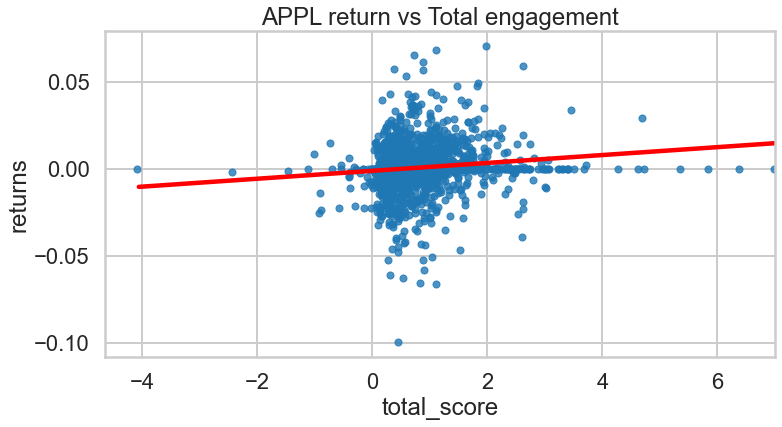

In [ ]:
#Visualize relationship between stock return and total score
sns.regplot(x='total_score', y="returns", data=Apple_visual_group, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("APPL return vs Total engagement")
plt.show()

In [ ]:
#Filter data for positive tweets only
Apple_pos = Apple_visual[Apple_visual['score'] == 'Positive']
Apple_pos.head()

,post_date,score,total_score,returns,close_value
3,2015-01-01,Positive,10.0,0.0,110.38
4,2015-01-01,Positive,0.0,0.0,110.38
5,2015-01-01,Positive,0.0,0.0,110.38
6,2015-01-01,Positive,1.0,0.0,110.38
13,2015-01-01,Positive,0.0,0.0,110.38


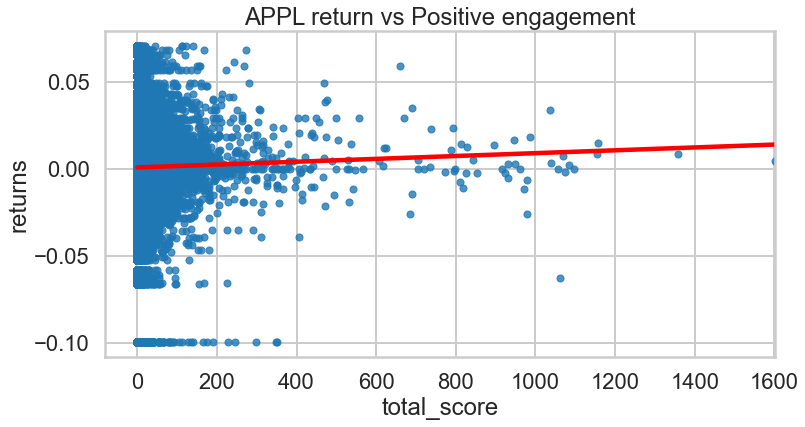

In [ ]:
#Visualize relationship between stock return and total score for positive tweets only
sns.regplot(x='total_score', y="returns", data=Apple_pos, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("APPL return vs Positive engagement")
plt.show()

In [ ]:
#Filter data for negative tweets only
Apple_neg = Apple_visual[Apple_visual['score'] == 'Negative']
Apple_neg.head()

,post_date,score,total_score,returns,close_value
10,2015-01-01,Negative,-0.0,0.0,110.38
31,2015-01-01,Negative,-0.0,0.0,110.38
40,2015-01-01,Negative,-1.0,0.0,110.38
51,2015-01-01,Negative,-0.0,0.0,110.38
60,2015-01-01,Negative,-3.0,0.0,110.38


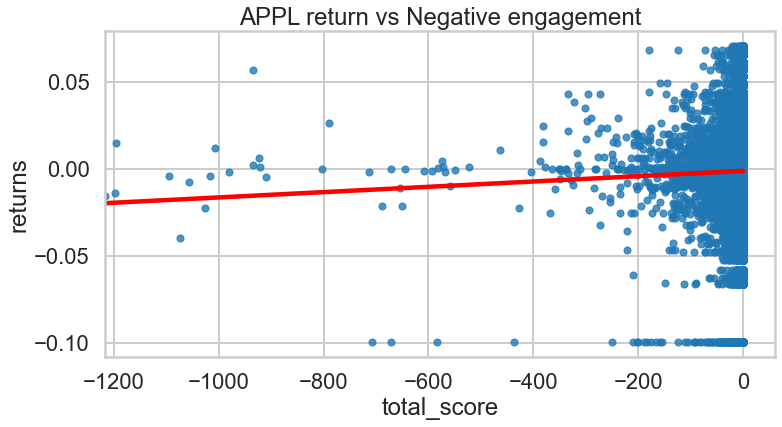

In [ ]:
#Visualize relationship between stock return and total score for negative tweets only
sns.regplot(x='total_score', y="returns", data=Apple_neg, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("APPL return vs Negative engagement")
plt.show()

In [ ]:
Total_pos_tweets = Apple_pos.groupby('post_date').mean('total_score')
Total_pos_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,12.134454,0.000000,110.38
2015-01-02,3.029508,-0.009513,109.33
2015-01-03,0.646067,0.000000,109.33
2015-01-04,2.633663,0.000000,109.33
2015-01-05,1.113734,-0.028172,106.25


In [ ]:
Total_neg_tweets = Apple_neg.groupby('post_date').mean('total_score')
Total_neg_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,-2.404762,0.000000,110.38
2015-01-02,-1.122699,-0.009513,109.33
2015-01-03,-0.235294,0.000000,109.33
2015-01-04,-0.636364,0.000000,109.33
2015-01-05,-1.052381,-0.028172,106.25


<ipython-input-94-db819bf9abf1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Apple_returns['returns'] = Apple_returns['returns'].apply(lambda returns: returns*50)


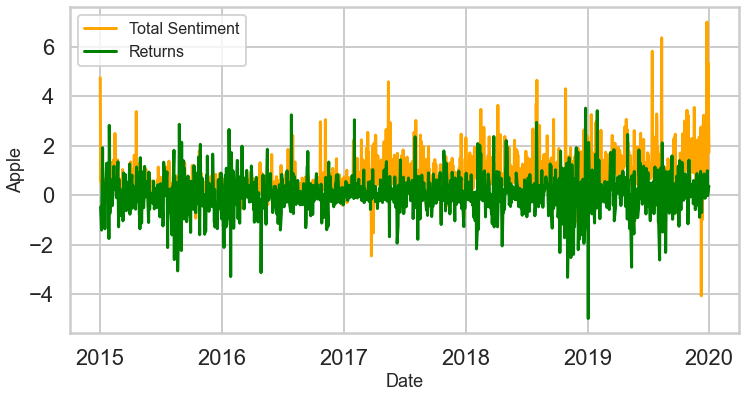

In [ ]:
#Visualize stock return and total score of sentiment per day.
Apple_returns = Apple_visual_group[Apple_visual_group['returns'] != 0]
Apple_returns['returns'] = Apple_returns['returns'].apply(lambda returns: returns*50)
plt.xlabel("Date" , fontsize = 18)
plt.ylabel("Apple", fontsize = 18)
sns.lineplot(
data = Apple_posneg,
        x = 'post_date',
        y = 'total_score', 
        color = 'orange'
    )
sns.lineplot(
data = Apple_returns,
        x = 'post_date',
        y = 'returns', 
        color = 'green'
    )
#"Positive Sentiment", "Negative Sentiment",
plt.legend(labels=["Total Sentiment", "Returns"],fontsize = 16)